Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images

Variable Description

Variance: A numerical measurement related to the variance of the image pixel values.
Skewness: A measure of the asymmetry of the image pixel value distribution.
Curtosis: A measure of the curvature of the image pixel value distribution.
Entropy: A measure of the randomness or complexity of the image
Class:Whether notes are genuine or counterfeit.

**Importing the Relevant Libraries**

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import sklearn
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df=pd.read_csv("/content/BankNote_Authentication.csv")

In [4]:
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [5]:
df.shape

(1372, 5)

We have 1372 rows and 5 columns in data set . data set have dependent and independent variables.


In [6]:
df.describe(include='all')

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


The five-number summary is a descriptive statistic that provides a concise overview of the distribution of a numerical data set. It consists of five key values: the minimum, first quartile (Q1), median (Q2), third quartile (Q3), and maximum. These values help you understand the spread and central tendency of the data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [8]:
df.isnull().apply(lambda x: (x.sum(), x.sum()/df.shape[0] *100)).transpose()

,0,1
variance,0.0,0.0
skewness,0.0,0.0
curtosis,0.0,0.0
entropy,0.0,0.0
class,0.0,0.0


**We have  no  missing values in  Datasets,Having complete data without any missing values is ideal for conducting accurate and reliable analyses. It ensures that you can make informed decisions and draw meaningful insights from your data**

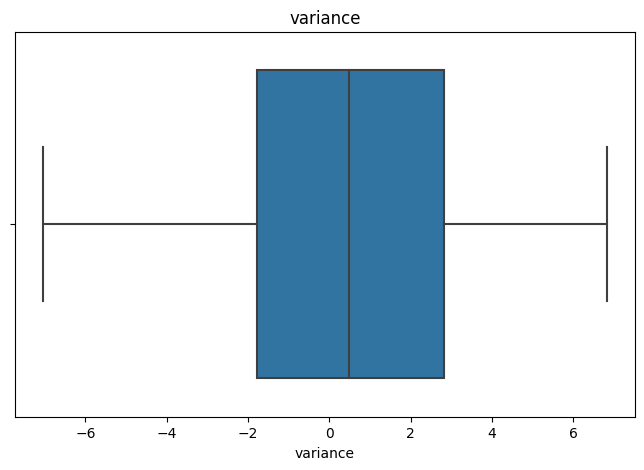

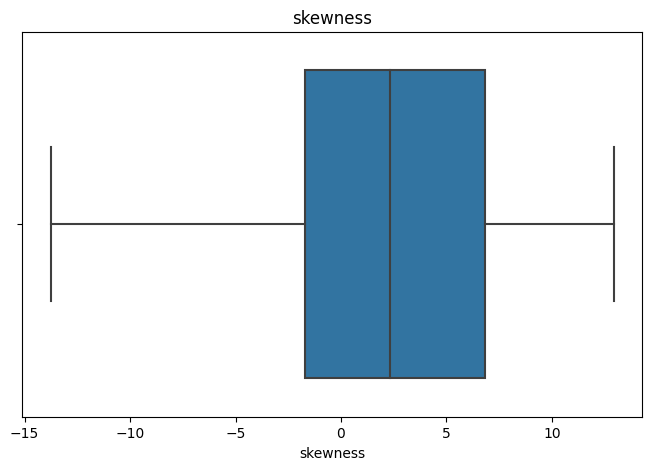

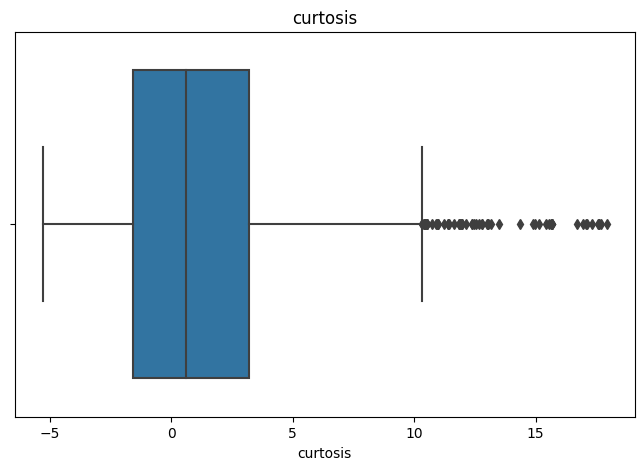

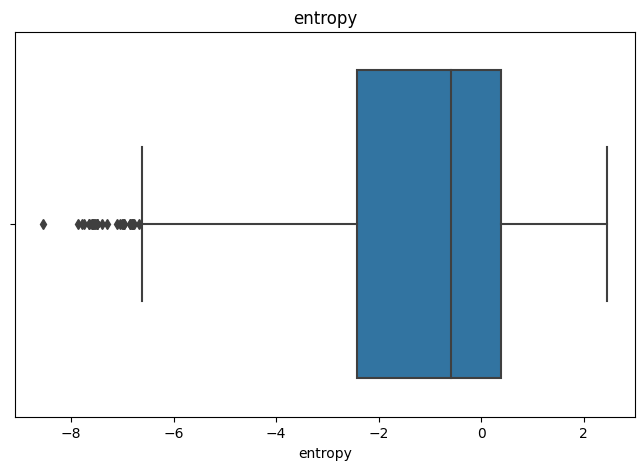

In [15]:
for column in df.drop(columns="class"):
    plt.figure(figsize=(8,5))
    sns.boxplot(x=column, data=df)
    plt.title(column)

**The Box Plots above clearly show  "Outliers" for the columns "Entropy","curtosis".Outliers are extreme values that fall a long way outside of the other observations. In a small dataset, the impact of an outlier can be much greater, since it will have a heavy weight for the model**


**Handling the Outliers**

In [16]:
df[["curtosis"]].describe()

,curtosis
count,1372.000000
mean,1.397627
std,4.310030
min,-5.286100
25%,-1.574975
50%,0.616630
75%,3.179250
max,17.927400


**With the describe method of pandas, we can see our data’s Q1 (%25) and Q3 (%75) percentiles. We can calculate our IQR point and boundaries (with 1.5)**

In [17]:
df["curtosis"].quantile(0.25)

-1.574975

In [18]:
df["curtosis"].quantile(0.75)

3.1792499999999997

In [48]:
Q1_curtosis=df["curtosis"].quantile(0.25)
Q3_curtosis=df["curtosis"].quantile(0.75)
IQR_curtosis=Q3_curtosis-Q1_curtosis

In [50]:
IQR_curtosis

4.754225

In [54]:
lower_llm_curtosis=Q1_curtosis-1.5*IQR_curtosis
upper_llm_curtosis=Q3_curtosis+1.5*IQR_curtosis

In [52]:
lower_llm_curtosis

-8.7063125

In [55]:
upper_llm_curtosis

10.3105875

In [56]:
df["entropy"].describe()

count    1372.000000
mean       -1.191657
std         2.101013
min        -8.548200
25%        -2.413450
50%        -0.586650
75%         0.394810
max         2.449500
Name: entropy, dtype: float64

In [57]:
df["entropy"].quantile(0.25)

-2.41345

In [58]:
df["entropy"].quantile(0.25)

-2.41345

In [59]:
Q1_entropy=df["entropy"].quantile(0.25)
Q3_entropy=df["entropy"].quantile(0.75)
IQR_entropy=Q3_entropy-Q1_entropy

In [60]:
IQR_entropy

2.80826

In [61]:
lower_llm_entropy=Q1_entropy-1.5*IQR_entropy
upper_llm_entropy=Q3_entropy+1.5*IQR_entropy

In [62]:
lower_llm_entropy

-6.62584

In [63]:
upper_llm_entropy

4.6072

**Our upper boundary of curtosis is 10.31 and our lower boundary is -8.70.
upper boundary of entropy is 4.6 and our lower boundary is -6.6 This means that these values between 10.31,-8.70,4.6 and -6.6 are acceptable but those outside mean there are outliers. So we need to handle them because they corrupt our data. With a small dataset, removing outliers might lead to a significant loss of information, potentially affecting the representativeness of your data.to avoid this we will be using log transformation**

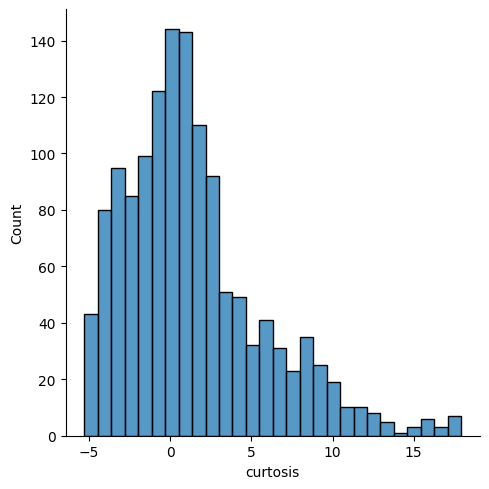

In [30]:
sns.displot(df["curtosis"])

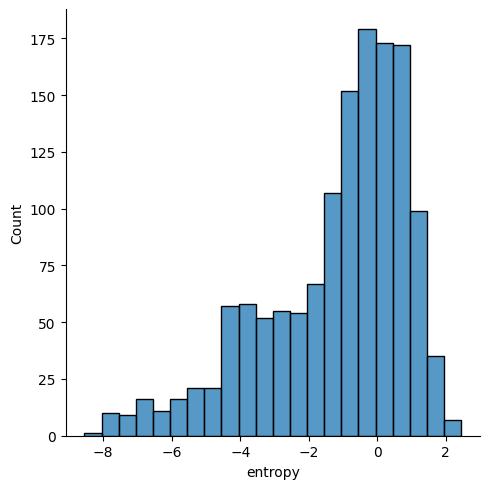

In [64]:
sns.displot(df["entropy"])

**There are many outliers and the data is right and left-skewed. Log transformation will transform data to normal or close to normal. Let’s apply the log transformation to reduce the variability of data**

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-68-fa6046856997>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(df[column]))
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-68-fa6046856997>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with

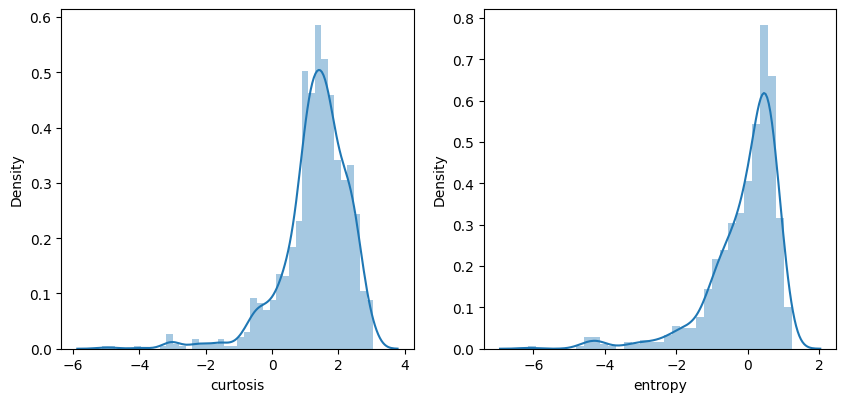

In [68]:
columns = ['curtosis','entropy']

plt.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    df[column]+=1
    ax = plt.subplot(3,2,plotnumber)
    sns.distplot(np.log(df[column]))
    plt.xlabel(column,fontsize=10)
    plotnumber+=1
plt.show()

After log transformation, rest of the columns look fine


**let's see how balanced our dataset in terms of given target classes:**

<Axes: >

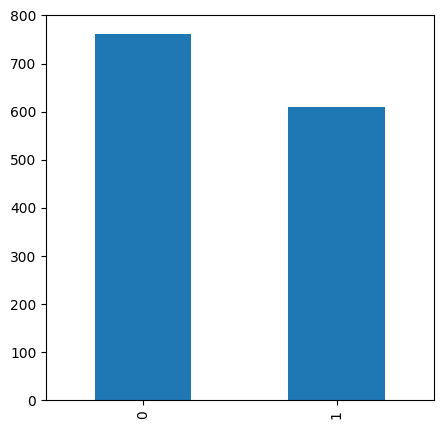

In [69]:
plt.rcParams['figure.figsize'] = [5, 5]
df['class'].value_counts().plot(kind='bar')

**We can clearly see that the dataset is  balanced**

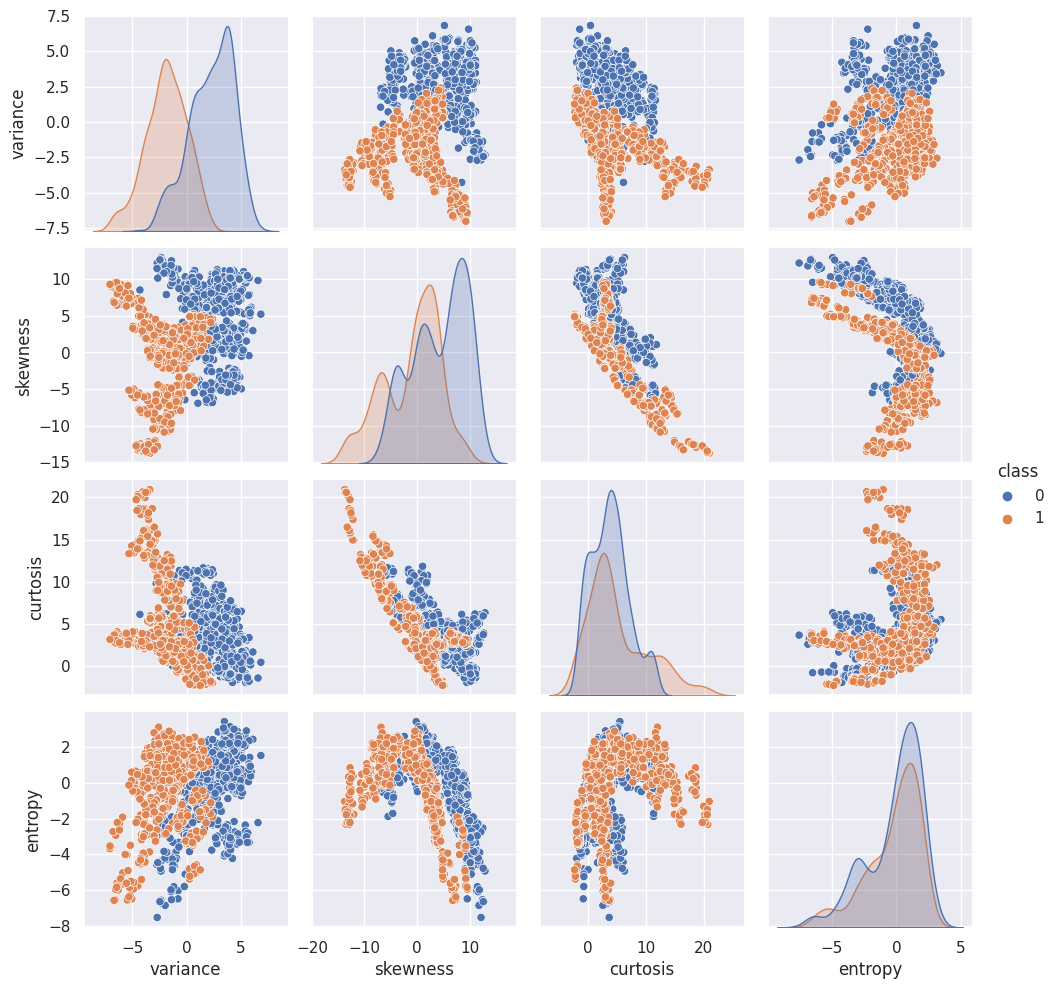

In [71]:
sns.set()
sns.pairplot(df,hue="class")

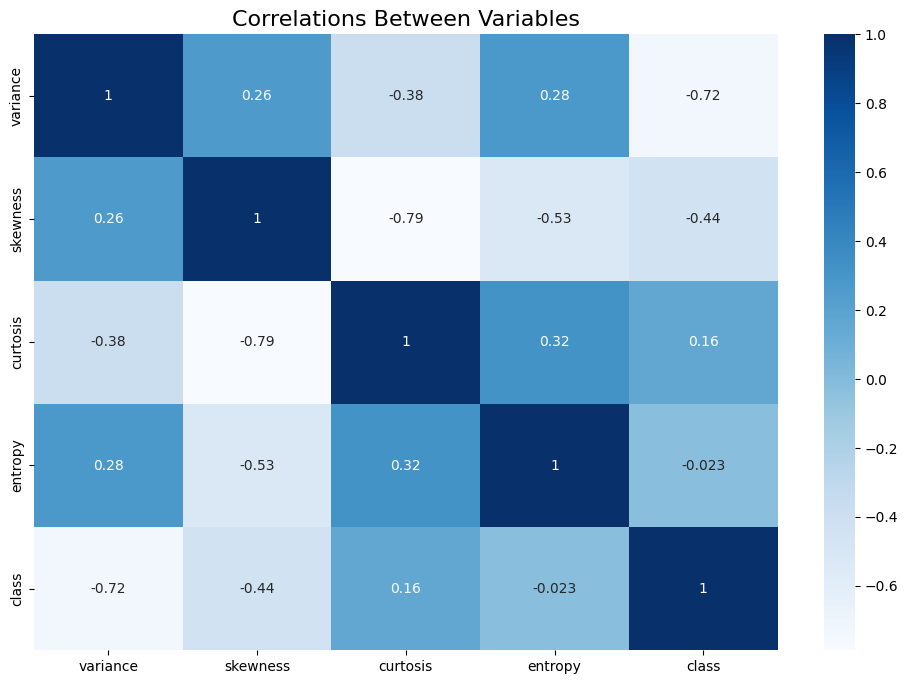

In [70]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="Blues")
plt.title("Correlations Between Variables", size=16)
plt.show()

We can go ahead with training our model on this data

In [72]:
x, y = df.values[:, :-1], df.values[:, -1]


In [73]:
le = LabelEncoder()
y = le.fit_transform(y)

In [74]:
# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)  # 70% training and 30% test

In [75]:
#print the shape of the train and test data values
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(960, 4)
(412, 4)
(960,)
(412,)


In [76]:
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras import Sequential

In [77]:
kerasmodel = Sequential()
kerasmodel.add(Dense(12, activation='relu', input_shape=(x.shape[1],)))
kerasmodel.add(Dense(4, activation='relu'))
kerasmodel.add(Dense(1,activation='sigmoid'))

In [78]:
kerasmodel.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [79]:
kerasmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                60        
                                                                 
 dense_1 (Dense)             (None, 4)                 52        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


In [80]:
history=kerasmodel.fit(x_train,y_train,batch_size=10,epochs=50,validation_split=0.1)

Epoch 1/50
87/87 [==============================] - 6s 6ms/step - loss: 0.9930 - accuracy: 0.5625 - val_loss: 0.6276 - val_accuracy: 0.6562
Epoch 2/50
87/87 [==============================] - 0s 5ms/step - loss: 0.5547 - accuracy: 0.7593 - val_loss: 0.4707 - val_accuracy: 0.7812
Epoch 3/50
87/87 [==============================] - 1s 6ms/step - loss: 0.4247 - accuracy: 0.8600 - val_loss: 0.3620 - val_accuracy: 0.8750
Epoch 4/50
87/87 [==============================] - 1s 6ms/step - loss: 0.3003 - accuracy: 0.9005 - val_loss: 0.2636 - val_accuracy: 0.9167
Epoch 5/50
87/87 [==============================] - 1s 6ms/step - loss: 0.2227 - accuracy: 0.9062 - val_loss: 0.2183 - val_accuracy: 0.9271
Epoch 6/50
87/87 [==============================] - 0s 4ms/step - loss: 0.1810 - accuracy: 0.9190 - val_loss: 0.1788 - val_accuracy: 0.9479
Epoch 7/50
87/87 [==============================] - 0s 4ms/step - loss: 0.1508 - accuracy: 0.9306 - val_loss: 0.1473 - val_accuracy: 0.9583
Epoch 8/50
87/87 [==

**In summary, the provided output shows the progress of training a model over 50 epochs. It indicates that the model is achieving very low loss values and high accuracies on both the training and validation datasets. This suggests that the model is learning the training data well and generalizing effectively to unseen validation data. However, it's important to also consider the model's performance on completely new and unseen data to assess its overall effectiveness.**

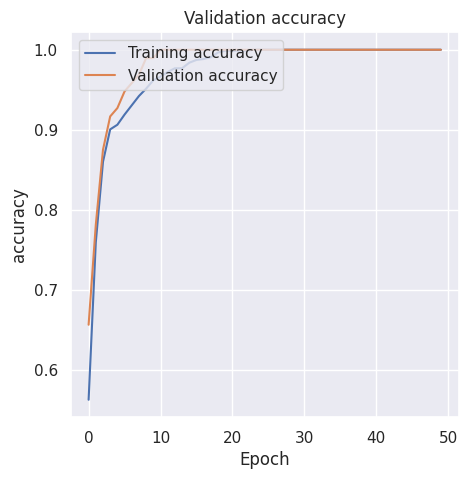

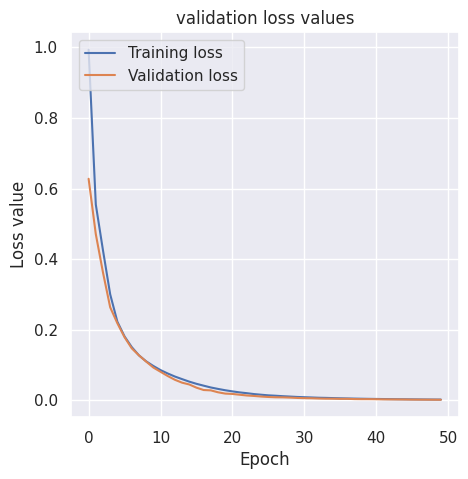

In [81]:

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [82]:
#train accuracy
_,accuracy=kerasmodel.evaluate(x_train,y_train)
print('The train accuracy:%2f' % (accuracy*100))

30/30 [==============================] - 0s 3ms/step - loss: 0.0019 - accuracy: 1.0000
The train accuracy:100.000000


In [83]:
loss = kerasmodel.evaluate(x_test, y_test)
print(loss)

13/13 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
[0.001890120911411941, 1.0]


In [84]:
from sklearn.metrics import accuracy_score

y_pred = (kerasmodel.predict(x_test) > 0.5).astype("int32")
accuracy_score(y_test,y_pred)

13/13 [==============================] - 0s 2ms/step


1.0

In [85]:
classification_report(y_test,y_pred.round())

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00       229\n           1       1.00      1.00      1.00       183\n\n    accuracy                           1.00       412\n   macro avg       1.00      1.00      1.00       412\nweighted avg       1.00      1.00      1.00       412\n'

**accuracy is good considering very less numbers of examples are available in Training sets.The fewer samples for training, the more models can fit our data. In an extreme example (a), for just one training point, any model will be able to "explain" it, however simple or complex the model may be. As we get to have more samples (b, c), fewer models are able to explain them**